# Example Notebook #2 - Factor Portfolio
In this notebook, we take a look at the problem of portfolio allocation from a dynamic standpoint of asset selection. In this case we assume that we have a risk model in the general form $
x_{i, t, k}=\alpha_{i, k}+\beta_{1, i, k} f_{1, t, k}+\beta_{2, i, k} f_{2, t, k}+\cdots+\beta_{m, i, k} f_{m, t, k}+\epsilon_{i, t, k}
$ for asset $k$. We would like to construct a single-factor portfolio that given a set of parameter estimates $\boldsymbol{\beta}_t$ constructs a single factor portfolio by taking a long position or long-short position by constructing a quantile: $
Q_{\beta_t}(p):=\inf \{\beta_t \in \mathbb{R}: p \leq F(x)\}
$. Then for example a long-short portfolio can be constructed by mapping a set of investor defined weights $\boldsymbol{w} \to Q_{\beta^{value}_t}(0.9), Q_{\beta^{value}_t}(0.1)$ constructing a single-factor long-short portfolio.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%load_ext autoreload
%autoreload 2
plt.style.use('bmh')

In [2]:
#dev on the fly
os.chdir('C:\\Users\matus\pysource\portfolio_swissknife')

In [3]:
from portfolio_swissknife import portfolio as ps
from portfolio_swissknife import models as rm

## 1. Loading Data and Setup
First we load our universe -- in this case some custom data that is stored locally. We process the data and create a `Portfolio` object that serves as a corpus for our universe.

In [4]:
#loading ext. data -- close prices of SPX
universe = pd.read_csv('ext_data/00_db_SPX__PX_LAST.csv', index_col = 0, parse_dates = True)
universe = universe[::-1].loc[:,universe.notna().all(axis=0)]
securities = [universe.columns[i].split(' ')[0] for i, _ in enumerate(universe.columns)]
universe = universe.loc['2014':]

In [5]:
port_universe = ps.Portfolio(securities)
port_universe.set_custom_prices(universe, 'daily')

Then a risk model is specified and created using the familiar `RiskModel` object and prices are loaded. To construct a portfolio using a nonparametric sort we call the method `.rolling_factor_selection` that conducts and out-of-sample rolling estimation of all of the betas in our prespecified risk model. 


In [8]:
factors = ['SPY', 'VLUE', 'SIZE', 'QUAL', 'MTUM', 'USMV']
rm_universe = rm.RiskModel(port_universe, factors)
rm_universe.get_prices('monthly')

[*********************100%***********************]  6 of 6 completed


In [9]:
rm_universe.prices

Adj Close                                                        
                MTUM       QUAL       SIZE         SPY       USMV       VLUE
Date                                                                        
2020-09-23       NaN        NaN        NaN         NaN        NaN        NaN
2017-02-01  77.19162  67.616684  70.251274  217.881790  43.905811  66.301552
2014-12-19       NaN        NaN        NaN         NaN        NaN        NaN
2014-06-20       NaN        NaN        NaN         NaN        NaN        NaN
2015-09-25       NaN        NaN        NaN         NaN        NaN        NaN
...              ...        ...        ...         ...        ...        ...
2014-03-21       NaN        NaN        NaN         NaN        NaN        NaN
2017-09-26       NaN        NaN        NaN         NaN        NaN        NaN
2020-03-25       NaN        NaN        NaN         NaN        NaN        NaN
2015-10-01  68.39357  59.515572  59.769073  186.447968  37.403130  56.090904
2018-09-21       NaN        NaN        NaN         NaN        NaN        NaN

[117 rows x 6 columns]

In [7]:
rm_universe.rolling_factor_selection(percentile = 10, method = 'linear',
                                     estimation_period = int(2*252), window = 22)

To simulate the strategy historically, we create the `FactorPotfolio` class inputting the universe `Portfolio` and `RiskModel` objects. We select the risk factor we would like to sort on, load our benchmark and discount rates and we are ready to backtest in the same way as we would backtest a portfolio with static assets.

## 2. Long Only Top Decile Value Factor Portfolio

In [9]:
factor_pf_vlue = ps.FactorPortfolio(port_universe, rm_universe, 'VLUE')
factor_pf_vlue.set_constraints(default = True)
factor_pf_vlue.set_benchmark('SPY')
factor_pf_vlue.set_discount('^TNX')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
factor_pf_vlue.historical_backtest(models=['EW','GMV','RP','MDD'],frequency=22, estimation_period=int(2*252))

C:\Users\matus\anaconda3\envs\dev01\lib\site-packages\portfolio_swissknife\metrics.py:193: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt((nu_fit - 2) / nu_fit) * t.ppf(1 - alpha, nu_fit) * sig_fit_norm - mu_fit_norm


EW      GMV       RP      MDD
Average Returns           19.52%   14.49%   15.86%   11.38%
CAGR                      16.42%   13.09%   14.08%    6.67%
Volatility                44.18%   38.08%   39.83%   33.74%
CEQ                     -2.57149 -4.54353 -4.05395 -106.147
Max DD                    49.02%   37.62%   39.92%   68.88%
Skewness                    0.09    -0.37     0.02    -1.63
Kurtosis                   -2.99    -2.99    -2.99    -2.98
Sharpe Ratio                0.40     0.33     0.35     0.28
Sortino Ratio               0.72     0.67     0.72     0.33
Calmar Ratio               -0.40    -0.39    -0.40    -0.17
Pain Ratio                333.35   290.35   346.24    60.75
Turnover                  41.47%   21.88%   25.08%   35.03%
Reward to 95% Var            nan      nan      nan     6.20
Reward to 95% cVar          0.61     0.11     0.79     0.48
CoSkew with Benchmark      69.65    68.09    73.07    61.96
CoKurt within Benchmark    16.91    17.78    17.51     8.00

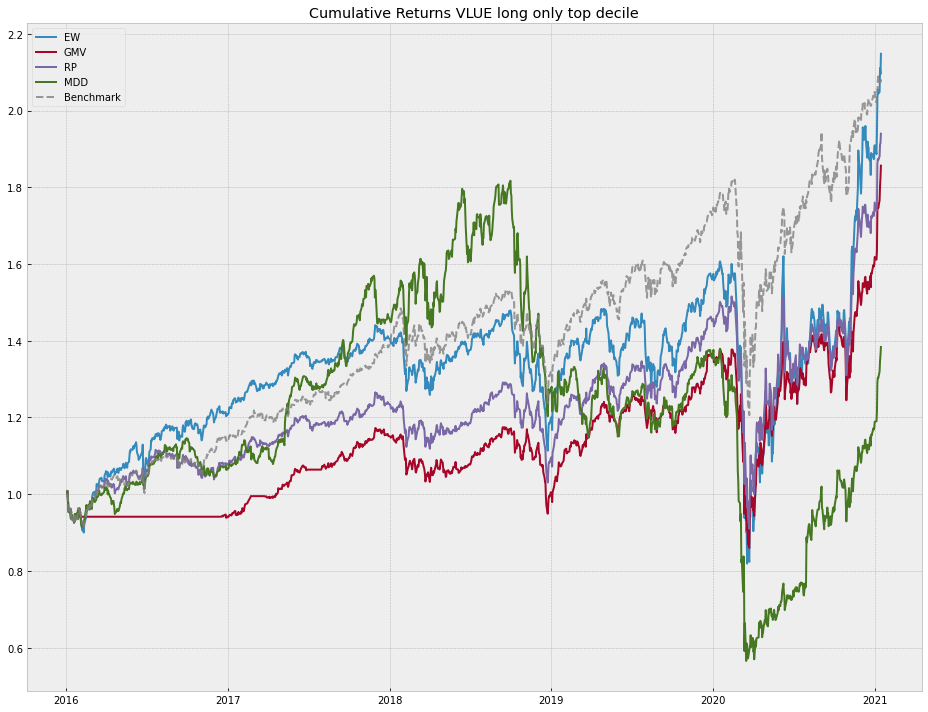

In [14]:
factor_pf_vlue.get_backtest_report(display_weights = False, title = 'VLUE long only top decile')

## 3. Long Only Top Decile Value Factor Portfolio

In [15]:
factor_pf_mtum = ps.FactorPortfolio(port_universe, rm_universe, 'MTUM')
factor_pf_mtum.set_constraints(default = True)
factor_pf_mtum.set_benchmark('SPY')
factor_pf_mtum.set_discount('^TNX')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [16]:
factor_pf_mtum.historical_backtest(models=['EW','GMV','RP','MDD'],frequency=22, estimation_period=int(2*252))

In [17]:
factor_pf_mtum.backtest['EW']['returns'].shape

(1267,)

EW      GMV       RP      MDD
Average Returns           11.94%    9.74%   10.15%   10.33%
CAGR                      10.00%    8.23%    8.62%    6.04%
Volatility                34.56%   31.21%   31.86%   32.15%
CEQ                     -5.33907 -5.86846 -5.78357 -124.235
Max DD                    37.12%   35.41%   34.63%   62.24%
Skewness                   -0.51    -0.79    -0.70    -2.29
Kurtosis                   -2.99    -2.99    -2.99    -2.97
Sharpe Ratio                0.29     0.25     0.26     0.26
Sortino Ratio               0.53     0.47     0.49     0.30
Calmar Ratio               -0.32    -0.27    -0.29    -0.17
Pain Ratio                166.10   188.89   178.03    67.27
Turnover                  19.96%   17.06%   18.69%   21.49%
Reward to 95% Var           3.24     2.84     3.18     1.99
Reward to 95% cVar          0.94     0.92     0.89     0.62
CoSkew with Benchmark      78.25    71.95    76.46    61.47
CoKurt within Benchmark    13.31    12.31    12.73     7.53

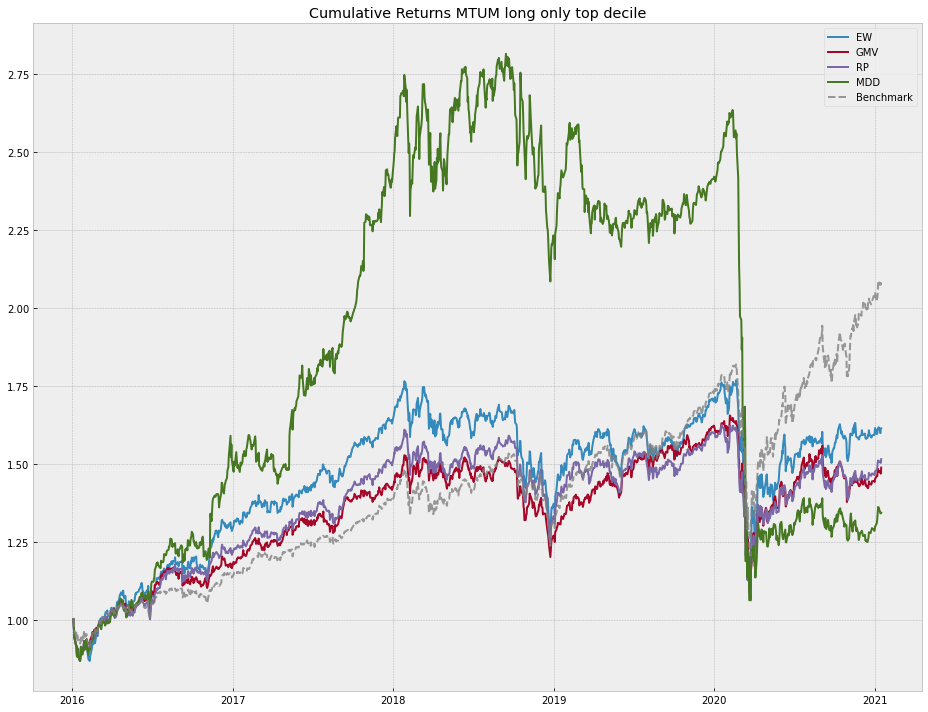

In [18]:
factor_pf_mtum.get_backtest_report(display_weights = False, title = 'MTUM long only top decile')

## 4. 130 - 30 Long Short Momentum Factor Portfolio

In [41]:
factor_pf_mtum = ps.FactorPortfolio(port_universe, rm_universe, 'MTUM')
factor_pf_mtum.set_constraints(default = True)
factor_pf_mtum.set_benchmark('SPY')
factor_pf_mtum.set_discount('^TNX')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [42]:
factor_pf_mtum.historical_backtest(models=['EW','GMV','RP','MDD'],frequency=22,
                                   long_only = False, long_exposure = 1.3, short_exposure = 0.3,
                                   estimation_period=int(2*252))

EW      GMV       RP      MDD
Average Returns           10.06%    7.19%    7.73%    7.97%
CAGR                       7.56%    5.09%    5.70%    1.61%
Volatility                31.73%   26.83%   27.80%   28.24%
CEQ                     -5.80105 -6.22016 -6.17508 -6.14904
Max DD                    36.71%   32.90%   32.54%   70.18%
Skewness                   -0.39    -0.56    -0.53    -2.11
Kurtosis                   -2.99    -2.99    -2.99    -2.98
Sharpe Ratio                0.25     0.19     0.21     0.21
Sortino Ratio               0.41     0.29     0.33     0.18
Calmar Ratio               -0.27    -0.22    -0.24    -0.11
Pain Ratio                106.86   108.74   107.68    42.44
Turnover                  19.96%   17.06%   18.69%   21.49%
Reward to 95% Var           2.21     1.74     1.97     1.16
Reward to 95% cVar          0.82     0.66     0.69     0.44
CoSkew with Benchmark      71.76    58.74    66.01    51.57
CoKurt within Benchmark     9.82     7.22     8.09     3.81

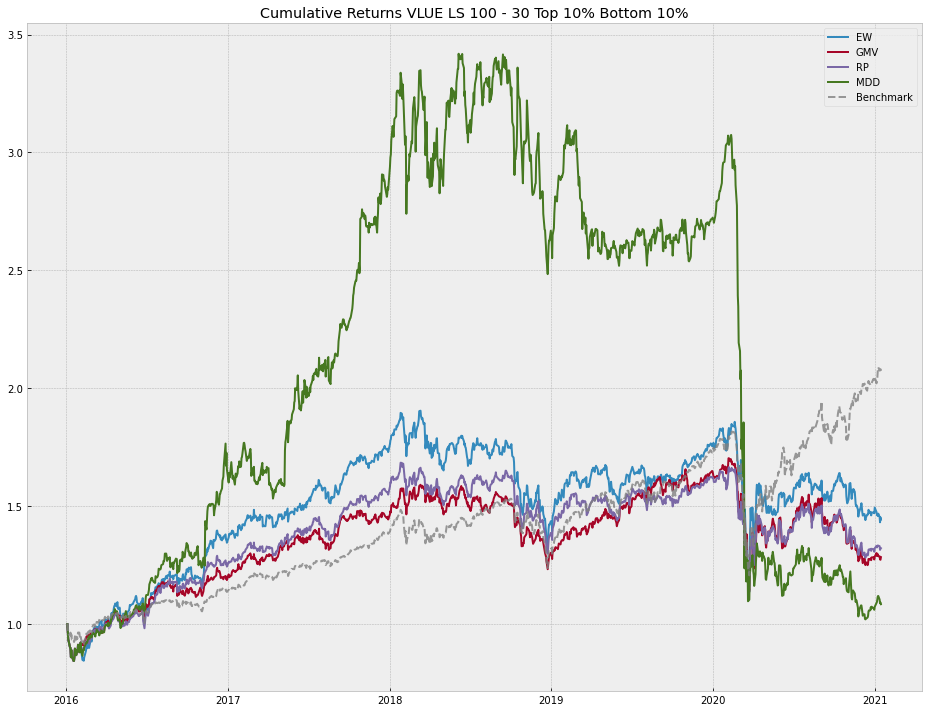

In [45]:
factor_pf_mtum.get_backtest_report(display_weights = False, title = 'VLUE LS 100 - 30 Top 10% Bottom 10%')